# Probabilistic RNN
In this notebook, we show an example of how a probabilistic RNN can be used with darts.
This type of RNN was inspired by, and is almost identical to DeepAR: https://arxiv.org/abs/1704.04110

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihoodModel

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## Variable noise series
As a toy example we create a target time series that is created by taking the some of a sine wave and a gaussian noise series. To make things interesting, the intensity of the gaussian noise is also modulated by a sine wave (with a different frequency). This means that the effect of the noise gets stronger and weaker in an oscillating fashion. The idea is to test whether a probabilistic RNN can model this oscillating uncertainty in its predictions.

In [4]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (tg.sine_timeseries(length=length, value_frequency=0.02) + tg.constant_timeseries(length=length, value=1)) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

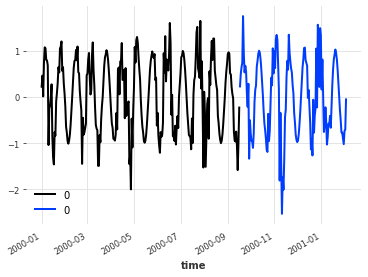

In [5]:
target_train.plot()
target_val.plot()

In the following we train a probabilistic RNN to predict the targets series in an autoregressive fashion, but also by taking into consideration the modulation of the noise component as a covariate which is known in the future. So the RNN has information on when the noise component of the target is severe, but it doesn't know the noise component itself. Let's see if the RNN can make use of this information.

In [7]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    training_length=50,
    input_chunk_length=20,
    likelihood=GaussianLikelihoodModel()
)

my_model.fit(target_train, 
             future_covariates=covariates, 
             verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

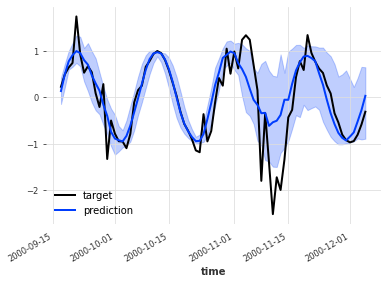

In [8]:
pred = my_model.predict(80, num_samples=50)
target_val.slice_intersect(pred).plot(label='target')
pred.plot(label='prediction')

We can see that, on top of correctly predicting the, granted, simple oscillatory behavior of the target, the RNN correctly expresses more uncertainty in its predictions when the noise component is higher.

## Daily energy production

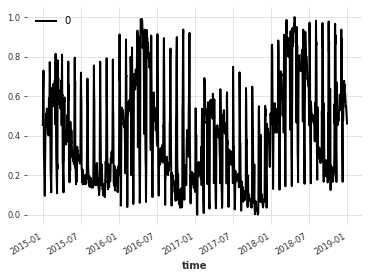

In [9]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
series_en = fill_missing_values(TimeSeries.from_dataframe(df3_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('20170901'))

# add the day as a covariate
day_series = datetime_attribute_timeseries(series_en_transformed, attribute='day', one_hot=True)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp('20170901'))

series_en_transformed.plot()

In [10]:
model_en = RNNModel(
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={'lr': 1e-3},
    random_state=0,
    training_length=300,
    input_chunk_length=300,
    likelihood=GaussianLikelihoodModel()
)


In [11]:
model_en.fit(series=train_en_transformed, 
             future_covariates=train_day,
             verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
backtest_en = model_en.historical_forecasts(series=series_en_transformed,
                                            future_covariates=day_series,
                                            num_samples=50,
                                            start=0.7,
                                            forecast_horizon=30,
                                            stride=5,
                                            retrain=False,
                                            verbose=True)

  0%|          | 0/83 [00:00<?, ?it/s]

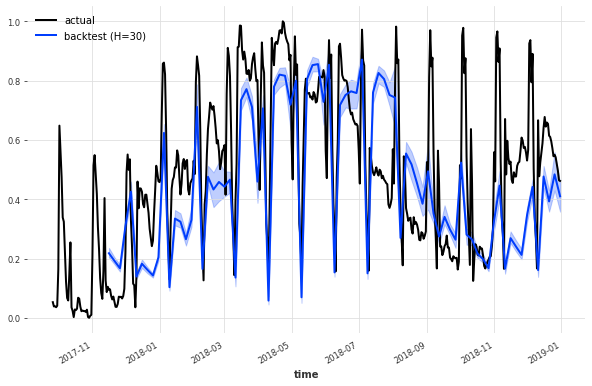

In [13]:
plt.figure(figsize=(10,6))
series_en_transformed[1000:].plot(label='actual')
backtest_en.plot(label='backtest (H=30)', low_quantile=0.01, high_quantile=0.99)
plt.legend();